# Extracting Gendered Constructions with spaCy

### The Ongoing Problem of Data-Driven Text Analysis

The process of extracting meaningful language patterns poses underlying challenges for any data-driven textual analysis. Here, this challenge is imagined as two-fold: analysts must determine which patterns are "meaningful" and analysts must apply the appropriate methods and tools to extract these meaningful patterns.

Analysts must also match guiding questions with an appropriate technique. They must be observant to how the methods and tools used to measure a corpus also give shape to the corpus and our analysis.

The purpose of this Notebook is thus to engage with this two-fold problem while text mining with spaCy NLP. 

In this exercise we will text mine a sample of the 2008 Subreddits: Worldnews, News, and Politics with the purpose of analyzing word co-occurance of grammatical gendered pronoun-verb pairs. These pairs are not necessarily consecutive, like bigrams, but instead share syntactic relations in a sentence.

This Notebook will ask a high-level, guiding question about gender: what kinds of actions are associated with male and female pronouns in this data set? 

### Getting Started

First import spaCy.

In [1]:
import spacy, warnings; warnings.simplefilter('ignore')
import pandas as pd

spaCy's language model can be loaded with `spacy.load()`. `spacy.load()` returns a `Language` object with the components and data required to process text such as a tagger and a tokenizer. 

For convention's-sake we will call our `Language` object `nlp`.

In [2]:
nlp = spacy.load('en_core_web_sm')

### Loading the Congress data

In [6]:
all_speech_files = glob.glob('/scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_*.txt')
CONGRESS_MIN_THRESHOLD = 91
CONGRESS_MAX_THRESHOLD = 120

speech_files = []

for fn in all_speech_files:
    number = int(fn.rsplit('_', 1)[-1].split('.')[0])
    if CONGRESS_MIN_THRESHOLD <= number <= CONGRESS_MAX_THRESHOLD:
        speech_files.append(fn)

speech_files.sort()
        
def parse_one(fn):
    print(f'Reading {fn}...')
    return pd.read_csv(fn, sep='|', encoding="ISO-8859-1", error_bad_lines=False, warn_bad_lines=False, quoting=csv.QUOTE_NONE)

speeches_df = pd.concat((parse_one(fn) for fn in speech_files))
speeches_df.dropna(how='any', inplace=True)

all_description_files = glob.glob('/scratch/group/oit_research_data/stanford_congress/hein-bound/descr_*.txt')
                                  
description_files = []

for fn in all_description_files:
    number = int(fn.rsplit('_', 1)[-1].split('.')[0])
    if CONGRESS_MIN_THRESHOLD <= number <= CONGRESS_MAX_THRESHOLD:
        description_files.append(fn)
        description_files.sort()
        
description_df = pd.concat((parse_one(fn) for fn in description_files))

all_data = pd.merge(speeches_df, description_df, on = 'speech_id')
all_data.fillna(0, inplace=True)
all_data.head()

Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_091.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_092.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_093.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_094.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_095.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_096.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_097.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_098.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_099.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_100.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_101.txt...
Reading /s

,speech_id,speech,chamber,date,number_within_file,speaker,first_name,last_name,state,gender,line_start,line_end,file,char_count,word_count
0,910000001,Mr. President. it is with deep regret that I a...,S,19690103,1,Mr. MANSFIELD,Unknown,MANSFIELD,Unknown,M,62,72,01031969.txt,320,57
1,910000002,The Chair lays before the Senate the following...,S,19690103,2,The VICE PRESIDENT,Unknown,Unknown,Unknown,Special,75,84,01031969.txt,315,50
2,910000003,(Edward E. Mansur) read as follows:,S,19690103,3,The legislative clerk,Unknown,Unknown,Unknown,Special,85,86,01031969.txt,35,6
3,910000004,The Chair lays before the Senate the credentia...,S,19690103,4,The VICE PRESIDENT,Unknown,Unknown,Unknown,Special,258,271,01031969.txt,443,78
4,910000005,The Senators to be sworn in will now present t...,S,19690103,5,The VICE PRESIDENT,Unknown,Unknown,Unknown,Special,1015,1021,01031969.txt,213,39


### Dates of Congress Data

The following code reads our sample into a pandas DataFrame.

In [4]:
import datetime
import pandas as pd
import numpy as np

In [5]:
import pandas as pd
import csv
import glob

In [7]:
all_data

,speech_id,speech,chamber,date,number_within_file,speaker,first_name,last_name,state,gender,line_start,line_end,file,char_count,word_count
0,910000001,Mr. President. it is with deep regret that I a...,S,19690103,1,Mr. MANSFIELD,Unknown,MANSFIELD,Unknown,M,62,72,01031969.txt,320,57
1,910000002,The Chair lays before the Senate the following...,S,19690103,2,The VICE PRESIDENT,Unknown,Unknown,Unknown,Special,75,84,01031969.txt,315,50
2,910000003,(Edward E. Mansur) read as follows:,S,19690103,3,The legislative clerk,Unknown,Unknown,Unknown,Special,85,86,01031969.txt,35,6
3,910000004,The Chair lays before the Senate the credentia...,S,19690103,4,The VICE PRESIDENT,Unknown,Unknown,Unknown,Special,258,271,01031969.txt,443,78
4,910000005,The Senators to be sworn in will now present t...,S,19690103,5,The VICE PRESIDENT,Unknown,Unknown,Unknown,Special,1015,1021,01031969.txt,213,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5658400,1110179264,Madam Speaker. on rollcall Nos. 662 and 661. I...,E,20101222,699,Ms. GRANGER,Unknown,GRANGER,Unknown,F,52713,52716,12222010.txt,118,23
5658401,1110179265,Madam Speaker. as I leave Congress as the peop...,E,20101222,700,Ms. KILPATRICK of Michigan,Unknown,KILPATRICK,Michigan,F,52723,52755,12222010.txt,1251,221
5658402,1110179266,Madam Speaker. on rolicall No. 658. I was unav...,E,20101222,701,Mr. HELLER,Unknown,HELLER,Unknown,M,52761,52763,12222010.txt,109,19
5658403,1110179267,Madam Speaker. on rollcall No. 658 my flight w...,E,20101222,702,Mr. PAULSEN,Unknown,PAULSEN,Unknown,M,52769,52772,12222010.txt,121,23


After reading our sample, we can transform it into a pandas series object for quicker processing. Please note that in doing so, we loose the "subreddit" column, which leaves us with just the text of the subreddits.

In [8]:
max(all_data['date'])

20101222

In [9]:
min(all_data['date'])

19690103

In [10]:
hyde_congress = all_data[(all_data.speaker == "Mr. HYDE")].copy()

In [11]:
hyde_congress

,speech_id,speech,chamber,date,number_within_file,speaker,first_name,last_name,state,gender,line_start,line_end,file,char_count,word_count
42536,910042537,Our proposal. of course. is subject to the rul...,H,19690617,581,Mr. HYDE,Unknown,HYDE,Unknown,M,37603,37610,06171969.txt,302,48
42538,910042539,Right. We have in our notice a possibility tha...,H,19690617,583,Mr. HYDE,Unknown,HYDE,Unknown,M,37612,37618,06171969.txt,259,44
42540,910042541,To establish regulations in the public interes...,H,19690617,585,Mr. HYDE,Unknown,HYDE,Unknown,M,37622,37625,06171969.txt,139,22
42542,910042543,It is our position that we would have legal au...,H,19690617,587,Mr. HYDE,Unknown,HYDE,Unknown,M,37630,37631,06171969.txt,79,15
42544,910042545,Well. we do not undertake in our shop to make ...,H,19690617,589,Mr. HYDE,Unknown,HYDE,Unknown,M,37640,37652,06171969.txt,468,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5265305,1090185256,Mr. Speaker. I am pleased to yield 5 minutes t...,H,20061208,401,Mr. HYDE,Unknown,HYDE,Unknown,M,43123,43126,12082006.txt,123,23
5265317,1090185268,Mr. Speaker. I believe I have the right to clo...,H,20061208,413,Mr. HYDE,Unknown,HYDE,Unknown,M,43333,43336,12082006.txt,132,27
5265320,1090185271,Mr. Speaker. the arguments that have been made...,H,20061208,416,Mr. HYDE,Unknown,HYDE,Unknown,M,43431,43451,12082006.txt,714,124
5265328,1090185279,Mr. Speaker. I yield back the balance of my time.,H,20061208,424,Mr. HYDE,Unknown,HYDE,Unknown,M,43873,43874,12082006.txt,49,10


In [12]:
hyde_congress = hyde_congress['speech'].copy()

In [13]:
hyde_congress

42536      Our proposal. of course. is subject to the rul...
42538      Right. We have in our notice a possibility tha...
42540      To establish regulations in the public interes...
42542      It is our position that we would have legal au...
42544      Well. we do not undertake in our shop to make ...
                                 ...                        
5265305    Mr. Speaker. I am pleased to yield 5 minutes t...
5265317    Mr. Speaker. I believe I have the right to clo...
5265320    Mr. Speaker. the arguments that have been made...
5265328    Mr. Speaker. I yield back the balance of my time.
5515891    Mr. Speaker. I rise in support of the Conferen...
Name: speech, Length: 7480, dtype: object

### Parsing Text with spaCy

As demonstrated in [Klein's Notebook](https://github.com/laurenfklein/emory-qtm340/blob/master/notebooks/class11-nlp-spacy-complete.ipynb), invoking `nlp` on a string of text will return a processed `Doc` object. Within each `Doc` object is a spaCy `token` object. From these `token` objects we can access a word's lemmatized form, its part-of-speech, and other attributes.

Unlike Klein's data, however, ours is in a series object where each row is a string of text. We must iterate through each row of the data frame with `nlp.pipe()`, which processes the data in small batches. To improve parsing time we can disable features that we will not use for this exercise like named entity recognition (or `ent`).

In [14]:
%%time
hyde_congress = list(nlp.pipe(hyde_congress, disable = ["ent"]))

CPU times: user 1min 24s, sys: 20.1 s, total: 1min 45s
Wall time: 1min 45s


In [15]:
hyde_congress[:8]

[Our proposal. of course. is subject to the rulemaking notice and subject to our consideration of comments that may be submitted by interested parties and subject. of course. to any action that Congress might take. The proposal would preclude the advertising of cigarettes on either radio or television.,
 Right. We have in our notice a possibility that some advertising regarding nicotine and tar content might be appropriate but that Is just in the notice for the advice of interested parties. The overall proposal is to bar cigarette advertising on radio and TV.,
 To establish regulations in the public interest and our basic theory is that these regulations would be justified to protect public health.,
 It is our position that we would have legal authority to prescribe such a rule.,
 Well. we do not undertake in our shop to make judgments on this. We rely entirely on the findings of the reports of the Departments of Health. Education. and Welfare. Federal Trade. and the Surgeon General. O

`reddit_sample_he_she_text` looks just like any other list, but it is actually a spaCy `doc` object where every word is a spaCy `token` object. We will explore the objects' attributes in the following section. 

### Processing spaCy `token` Objects for Part-of-Speech Extraction

For our analysis, we are just interested in the spaCy `token` objects inside the `doc` object. The `token` objects include attributes such as:

 - `.text`: the original word
 - `.lemma_`: the word's lemmatized form
 - `.pos_`: the word's part-of-speech
 - `.dep_`: the word's syntactic dependency
 - `.head.text`: the word upon which the present word is dependent

These attributes can be viewed by iterating through each `doc` object like the following code:

In [16]:
def extractTokens(spacy_doc_object):
    spacy_tokens = []
    for doc in spacy_doc_object:
        for token in doc:
            row = (token.text, token.lemma_, token.pos_, token.dep_, token.head.text)
            spacy_tokens.append(row)
    return spacy_tokens

congress_tokens = extractTokens(hyde_congress)

In [17]:
congress_tokens[:30]

[('Our', '-PRON-', 'DET', 'poss', 'proposal'),
 ('proposal', 'proposal', 'NOUN', 'ROOT', 'proposal'),
 ('.', '.', 'PUNCT', 'punct', 'proposal'),
 ('of', 'of', 'ADV', 'advmod', 'course'),
 ('course', 'course', 'ADV', 'ROOT', 'course'),
 ('.', '.', 'PUNCT', 'punct', 'course'),
 ('is', 'be', 'AUX', 'ROOT', 'is'),
 ('subject', 'subject', 'ADJ', 'acomp', 'is'),
 ('to', 'to', 'ADP', 'prep', 'subject'),
 ('the', 'the', 'DET', 'det', 'notice'),
 ('rulemaking', 'rulemake', 'VERB', 'compound', 'notice'),
 ('notice', 'notice', 'NOUN', 'pobj', 'to'),
 ('and', 'and', 'CCONJ', 'cc', 'notice'),
 ('subject', 'subject', 'ADJ', 'conj', 'notice'),
 ('to', 'to', 'ADP', 'prep', 'subject'),
 ('our', '-PRON-', 'DET', 'poss', 'consideration'),
 ('consideration', 'consideration', 'NOUN', 'pobj', 'to'),
 ('of', 'of', 'ADP', 'prep', 'consideration'),
 ('comments', 'comment', 'NOUN', 'pobj', 'of'),
 ('that', 'that', 'DET', 'nsubjpass', 'submitted'),
 ('may', 'may', 'VERB', 'aux', 'submitted'),
 ('be', 'be', 'AUX'

Before continuing, let's take a moment to observe the output of `reddit_tokens`.

`reddit_tokens` is split into one token per row. Alongside each token is: a) the token, b) the token's lemmatized form, c) the tokens part-of-speech, d) the token's syntactic function, and e) the token's "head", or the token to which it syntactically depends.

### Extracting Parts-of-Speech from Parsed Reddit Text

Now we can begin extracting grammatical parts-of-speech for the purpose of looking for language trends. The following code extracts grammatical pairs where the subject is tagged as a noun subject or passive noun subject, and is also a "child" of a verb. 

The verb is lemmatized to prevent counting inflectional verbs separately from their base form.

In [18]:
from spacy.symbols import nsubj, nsubjpass, VERB

def extractPairs(spacy_doc_object):
    pairs = []
    for doc in spacy_doc_object:
        for subject in doc:
            if subject.dep == nsubj or subject.dep == nsubjpass and subject.head.pos == VERB:
                extracted_pairs = subject.text, subject.head.lemma_
                concat_extracted_pairs = ' '.join(extracted_pairs)
                pairs.append(str(concat_extracted_pairs))
    return pairs

pairs = extractPairs(hyde_congress)

In [19]:
pairs[:30]

['that submit',
 'Congress take',
 'proposal preclude',
 'We have',
 'advertising be',
 'that be',
 'proposal be',
 'theory be',
 'regulations justify',
 'It be',
 'we have',
 'we undertake',
 'We rely',
 'we cite',
 'which issue',
 'department say',
 'cause be',
 'We base',
 'Welfare give',
 'it give',
 'I mention',
 'We have',
 'that publish',
 'herein present',
 'expectancy reduce',
 'who smoke',
 'who smoke',
 'I think',
 'we have',
 'Commission make']

`pairs` is a list subjects followed by verbs.

For the sake of counting and matching with words regardless of case, we can transform all words to lower case.

In [20]:
lowercase_pairs = [word.lower() for word in pairs]

In [21]:
lowercase_pairs[:30]

['that submit',
 'congress take',
 'proposal preclude',
 'we have',
 'advertising be',
 'that be',
 'proposal be',
 'theory be',
 'regulations justify',
 'it be',
 'we have',
 'we undertake',
 'we rely',
 'we cite',
 'which issue',
 'department say',
 'cause be',
 'we base',
 'welfare give',
 'it give',
 'i mention',
 'we have',
 'that publish',
 'herein present',
 'expectancy reduce',
 'who smoke',
 'who smoke',
 'i think',
 'we have',
 'commission make']

<div class="alert alert-block alert-info">
Remember to capitalize I before turning in your paper.
</div>

We can narrow these results to just pairs containing gendered pronouns for the purpose of exploring our guiding question: what kinds of actions are associated with male and female pronouns in the decade 1870?

### Filtering for Gendered Pronoun-Verb Pairs

The goal of this Notebook is to extract gendered pronoun-verb pairs and create visualizations that compare male pronoun-verb pairs and female pronoun-verb pairs. First, however, we will just extract pairs with the pronoun he.

We can search for "he" and its grammatical verbs by treating "he" as a regular expression (or sequence of characters that define a search pattern). The following code defines our regular expression, `('he ')`, and creates a variable for each pair that contains a match.

In [27]:
import re

def extractMalePairs(pairs):
    regex = re.compile('he ')
    male = [word for word in lowercase_pairs if regex.match(word)]
    return male

male = extractMalePairs(lowercase_pairs)

In [28]:
male[:30]

['he add',
 'he say',
 'he be',
 'he forego',
 'he give',
 'he come',
 'he exult',
 'he be',
 'he make',
 'he emphasize',
 'he will',
 'he implement',
 'he say',
 'he say',
 'he go',
 'he protect',
 'he protect',
 'he have',
 'he show',
 'he get',
 'he become',
 'he arrest',
 'he say',
 'he intend',
 'he be',
 'he have',
 'he intend',
 'he elect',
 'he be',
 'he be']

Viewing just the first 30 lines of our lists shows us that our gendered pronoun-verb pairs contain stop words like be or say. Pairs containing a stop word can be removed. 

We can do this by first defining our stop words . . . 

In [29]:
stopwords = ['right', 'hon', 'general', 'mr', 'shall', 'majesty', 'exchequer', 'address', 'motion', 'bill',
             'earl', 'friend', 'chancellor', 'sense', 'object', 'suppose', 'amidst', 'noble', 'lord', 'agree',
             'speech', 'kind', 'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september',
             'october', 'november', 'december', 'order', 'held', 'hold', 'assembly', '£', 'humble', 'about', 'above',
             'across', 'address', 'after', 'afterwards', 'again', 'against', 'agree', 'all', 'almost', 'alone', 'along',
             'already', 'also', 'although', 'always', 'am', 'amidst', 'among', 'amongst', 'amount', 'an', 'and', 'another',
             'any', 'anyhow', 'anything', 'anyway', 'anywhere', 'april', 'are', 'around', 'as', 'at', 'back', 'be', 'was',
             'becames', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being',
             'beside', 'besides', 'between', 'beyond', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'do',
             'could', 'did', 'does', 'doing', 'done', 'down', 'due', 'during', 'each', 'either', 'else', 'elsewhere',
             'empty', 'enough', 'even', 'ever', 'everyone', 'everything', 'everywhere', 'except', 'few', 'first', 'for',
             'from', 'front', 'full', 'further', 'general', 'get', 'give', 'go', 'had', 'has', 'have', 'held', 'hence',
             'here', 'hereby', 'herein', 'hold', 'however', 'if', 'in', 'indeed', 'into', 'is', 'it', 'its', 'itself',
             'just', 'keep', 'kind', 'last', 'latter', 'least', 'less', 'made', 'make', 'many', 'me', 'meanwhile', 'might',
             'mine', 'more', 'most', 'mostly', 'move', 'much', 'must', 'name,' 'neither', 'never', 'nevertheless', 'next',
             'no', 'noble', 'nobody', 'none', 'nor', 'nothing', 'now', 'nowhere', 'of', 'off', 'often', 'on', 'one', 'once',
             'only', 'onto', 'or', 'other', 'others', 'otherwise', 'out', 'over', 'own', 'part', 'perhaps', 'please', 'put',
             'quite', 'rather', 'really', 'regarding', 'same', 'say', 'see', 'seem', 'seemed', 'seeming', 'seems', 'sense',
             'several', 'shall', 'should', 'show', 'side', 'since', 'so', 'some', 'someone', 'something', 'sometime',
             'still', 'such', 'suppose', 'take', 'than', 'that', 'the', 'then', 'there', 'thereby', 'therefore', 'these',
             'they', 'this', 'those', 'though', 'thus', 'to', 'together', 'too', 'top', 'toward', 'towards', 'under',
             'unless', 'until', 'up', 'upon', 'us', 'used', 'using', 'various', 'very', 'was', 'we', 'well', 'were', 'what',
             'whatever', 'when', 'when', 'whereby', 'whether', 'which', 'while', 'who', 'why', 'will', 'with', 'within',
             'without', 'would', 'yet', 'bright', 'mr.', 'hansard', 'lancashire', '[]', '£1', '000', 'russell', 'committee',
             'reading', 'learned', 'deal', 'time', 'royal', 'gentlemen', 'gentleman', 'year', 'years', 'affairs', 'affair',
             'academy', 'sir', 'thought', 'took', 'bring', 'brings', 'brought', 'forward', 'great', 'good', 'department',
             'treasury', 'second', 'take', 'taken', 'privy', 'member', 'robert', 'large', 'session', 'secretary', 'notice',
             'moment', 'think', 'believe', 'hope', 'ask', 'hear', 'beg', 'support', 'state', 'find', 'admit', 'wish',
             'refer', 'reply', 'know', 'feel', 'propose', 'understand', 'let', 'allow', 'like', 'receive', 'consider',
             'begin', 'tell', 'like', 'send', 'ought', 'come', 'intend', 'add', 'want', 'stand', 'suggest', 'remind',
             'use', 'mean', 'suggest', 's','manner','manager','mandate','manipulation','manufacturer','manufacture', 'maneuvering',
             'management','manifestation','manoeuvre','maneuver','manuevering']

. . . and then matching this list with our pairs to see whether any tokens match a stop word.

The following code removes stop words by a) splitting the pair into individual tokens, b) creating a variable, `tokens_filtered` for just words that do not match a stop word, and c) joining indiviudal words back together to make a pair.

In [30]:
tokens_joined = []

for pair in male:
    tokens = pair.split(" ")
    tokens_filtered = [word for word in tokens if not word in stopwords]
    tokens = " ".join(tokens_filtered)
    tokens_joined.append(str(tokens))

In [31]:
tokens_joined[:30]

['he',
 'he',
 'he',
 'he forego',
 'he',
 'he',
 'he exult',
 'he',
 'he',
 'he emphasize',
 'he',
 'he implement',
 'he',
 'he',
 'he',
 'he protect',
 'he protect',
 'he',
 'he',
 'he',
 'he',
 'he arrest',
 'he',
 'he',
 'he',
 'he',
 'he',
 'he elect',
 'he',
 'he']

We have a problem, however. After joining the individual words we are left with messy data: some strings only have one word because the other word was removed. 

We can remove these individual tokens by writing a line of logic that only keeps strings that are the length of two (i.e. strings that are pairs). 

In [32]:
def removeStopWords(pairs):
    keep_pairs = []
    for pair in pairs:
        tokens = pair.split(" ")
        tokens_filtered = [word for word in tokens if not word in stopwords]
        joined_tokens = " ".join(tokens_filtered)
        if len(tokens_filtered) == 2: # if string is length of two
            keep_pairs.append(str(joined_tokens)) # keep the string
    return keep_pairs

male_no_stopwords = removeStopWords(male)

In [33]:
male_no_stopwords[:30]

['he forego',
 'he exult',
 'he emphasize',
 'he implement',
 'he protect',
 'he protect',
 'he arrest',
 'he elect',
 'he impose',
 'he yield',
 'he involve',
 'he hit',
 'he join',
 'he nominate',
 'he graduate',
 'he isolate',
 'he cite',
 'he honor',
 'he serve',
 'he associate',
 'he possess',
 'he exemplify',
 'he leave',
 'he work',
 'he associate',
 'he perform',
 'he earn',
 'he win',
 'he hospitalize',
 'he note']

### Counting Gendered Pronoun-Verb Pairs

After aggregating gendered pronouns that syntactically depend on a verb, we can count their frequency.

The following code defines a function, `countWords()`, that creates a dictionary of every unique pair and its frequency. Any pair not already in the dictionary is added. If the pair is already part of the dictionary its count increments by 1.

In [34]:
def countWords(clean_data):
    ngrams_dict = {}
    for ngram in clean_data:
        if ngram in ngrams_dict:
            ngrams_dict[ngram] += 1
        else:
            ngrams_dict[ngram] = 1
    return ngrams_dict
            
male_dictionary = countWords(male_no_stopwords)

In [35]:
for kv in list(male_dictionary)[:30]:
    print(kv,  male_dictionary[kv])

he forego 1
he exult 1
he emphasize 1
he implement 1
he protect 3
he arrest 4
he elect 4
he impose 2
he yield 5
he involve 4
he hit 2
he join 11
he nominate 1
he graduate 5
he isolate 2
he cite 3
he honor 4
he serve 45
he associate 2
he possess 6
he exemplify 1
he leave 15
he work 10
he perform 11
he earn 5
he win 7
he hospitalize 1
he note 5
he represent 6
he write 14


Dictionaries do not store data in sequential order. This is because a dictionary is "hashable," and not linear like a list. While this makes dictionaries quick to process, its organization is not conducive to analysis.

Therefore, we will cast the pronoun-verb pairs and their counts to a pandas DataFrame.

In [36]:
male_pronoun_verb_counts = pd.DataFrame(male_dictionary.items(),columns = ['Pair','Count'])

In [37]:
male_pronoun_verb_counts

,Pair,Count
0,he forego,1
1,he exult,1
2,he emphasize,1
3,he implement,1
4,he protect,3
...,...,...
463,he cede,1
464,he commission,1
465,he invade,1
466,he postpone,1


After creating a pandas DataFrame with our pronoun-verb pairs we can arrange the frequency counts so pairs with the highest count are first.

In [38]:
male_pronoun_verb_counts.sort_values(by=['Count'], inplace=True, ascending=False)

In [39]:
male_pronoun_verb_counts

,Pair,Count
30,he consume,61
17,he serve,45
108,he talk,32
57,he need,19
139,he love,18
...,...,...
246,he awaken,1
244,he remove,1
243,he smile,1
242,he overthrow,1


<div class="alert alert-block alert-info">
Before we continue: one concern had by students was whether it is possible to save variables so that we would not have to rerun spaCy. The answer is: yes, but we need to be mindful of the variable's data structure. During points in our code we can transform our data structure (our dictionary, our list, etc.) to a pandas DataFrame and save the pandas DataFrame to a CSV file. A CSV file looks like an Excel spreadsheet and can be easily read back into your code. The following commented-out example shows how to save a CSV file and then read it back into your Notebook.
</div>

In [40]:
# male_pronoun_verb_counts.to_csv('male_pronoun_verb_counts.csv') # save your variable to a CSV file on disk
# loaded_male_pronoun_verb_counts = pd.read_csv('male_pronoun_verb_counts.csv') # load your CSV file 

### Visualizing our Results for Analysis

We are now ready to visualize our results: grammatical pronoun-verb pairs that show us which verbs are commonly associated with the pronoun he in our Reddit sample of "Worldnews," "News," and "Politics."

The following code takes a subset of the first 25 rows of `male_pronoun_verb_counts`.

In [41]:
top_male_pronoun_verb_counts = male_pronoun_verb_counts[:25].copy()

In [42]:
top_male_pronoun_verb_counts

,Pair,Count
30,he consume,61
17,he serve,45
108,he talk,32
57,he need,19
139,he love,18
21,he leave,15
29,he write,14
130,he miss,13
80,he learn,13
100,he permit,11


These top grammatical pairs can now be visualized with matplotlib. 

The following code imports matplotlib, sets the plot's size, and renders the visualization.

In [43]:
import matplotlib as plt

plt.rcParams['figure.figsize'] = [15, 10]

top_male_pronoun_verb_counts.sort_values(by=['Count'], inplace=True, ascending=True)

<AxesSubplot:title={'center':"Top Grammatical Pronoun-Verb Pairs with He: Searching Mr. Hyde's Speeches in Congress"}, ylabel='Pair'>

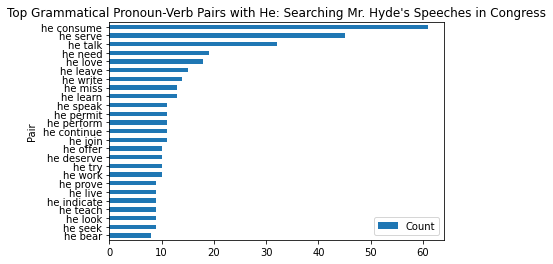

In [44]:
top_male_pronoun_verb_counts.plot.barh(x = "Pair", y = "Count",
            title = "Top Grammatical Pronoun-Verb Pairs with He: Searching Mr. Hyde's Speeches in Congress")

### Reiterating the Process to Extract Female Grammatical Pronouns and their Verbs 

We can reiterate the same process outlined above to extract the pronoun she and its grammatical verbs. The following code defines one new function (to extract female pronoun-verb pairs) and then calls our already defined functions to render a bar graph of top pairs.

<AxesSubplot:title={'center':"Top Grammatical Pronoun-Verb Pairs with He: Searching Mr. Hyde's Speeches in Congress"}, ylabel='Pair'>

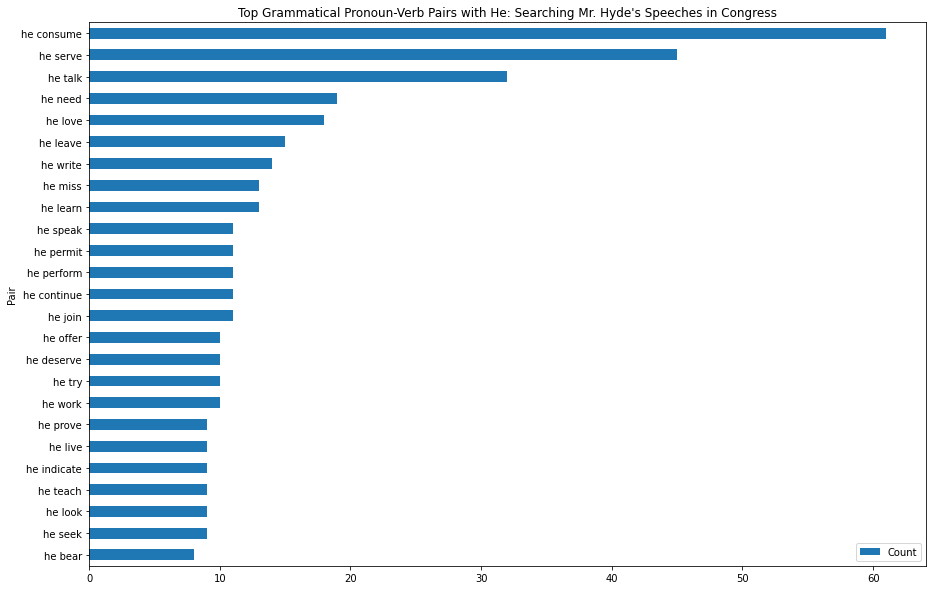

In [45]:
# extract grammatical pronoun-verb pairs where she is subject
def extractMalePairs(pairs):
    regex = re.compile('he ')
    male = [word for word in lowercase_pairs if regex.match(word)]
    return male

male = extractMalePairs(lowercase_pairs)

# remove stop words
male_no_stopwords = removeStopWords(male)

# create a dictionary with each unique pair and its frequency
male_dictionary = countWords(male_no_stopwords)

# create a data frame from our dictionary of grammatical pairs
male_pronoun_verb_counts = pd.DataFrame(male_dictionary.items(),columns = ['Pair','Count'])

# arrange in ascending order
male_pronoun_verb_counts.sort_values(by=['Count'], inplace=True, ascending=False)

# take a subset of the data
top_male_pronoun_verb_counts = male_pronoun_verb_counts[:25].copy()

# set the parameters of the visualization
plt.rcParams['figure.figsize'] = [15, 10]

# sort the pairs for visualization
top_male_pronoun_verb_counts.sort_values(by=['Count'], inplace=True, ascending=True)

# render visualization
top_male_pronoun_verb_counts.plot.barh(x = "Pair", y = "Count",
            title = "Top Grammatical Pronoun-Verb Pairs with He: Searching Mr. Hyde's Speeches in Congress")

### Extracting Adjectives that Modify the Words "Man" and "Woman"

To keep our data sets small, you can read in another subset of the Reddit data which includes just sentences with the word "man" or "woman." 

As mentioned, you can modiy the code in this Notebook to extract female adjective-noun pairs. To see what I mean, let's get started on this problem together.

We know we already have functions that count pairs, create DataFrames, and visualize our results. Therefore, we just need to change the code that determines which pairs are extracted. Instead of extracting noun-verb pairs we want to extract adjective-noun pairs. 

So, let's return to the `extractPairs()` function and modify it for our assignment. Instead of using the symbols `nsubj` (for noun subject), `nsubjpass` (for passive noun subject) and `VERB`, we will use `amod` (for adjectival modifier), `acomp` (for adjectival complement), and `NOUN`. 

In [46]:
from spacy.symbols import amod, acomp, NOUN

def extractAdjNounPairs(spacy_doc_object):
    pairs = []
    for doc in spacy_doc_object:
        for adjective in doc:
            if adjective.dep == amod or adjective.dep == acomp and adjective.head.pos == NOUN: # or adjective.dep == ccomp or adjective.dep == conj 
                extracted_pairs = adjective.text, adjective.head.lemma_
                concat_extracted_pairs = ' '.join(extracted_pairs)
                pairs.append(str(concat_extracted_pairs))
    return pairs

adjective_noun_pairs = extractAdjNounPairs(hyde_congress)

In [47]:
adjective_noun_pairs[:30]

['interested party',
 'interested party',
 'overall proposal',
 'public interest',
 'basic theory',
 'public health',
 'legal authority',
 'proposed rulemake',
 'important cause',
 'young man',
 'heavy smoker',
 'light smoker',
 'less pack',
 'unique situation',
 'such operation',
 'public interest',
 'clear bearing',
 'public interest',
 'public health',
 'several agency',
 'public interest',
 'overall determination',
 'public interest',
 'own responsibility',
 'public health',
 'official action',
 'public interest',
 'single instance',
 'obscene matter',
 'substantial amount']

Like our previous code, we can transform each pair to lower case so the same word with a different case is not counted separately. In other words, we don't want to count "Woman" and "woman" separately.

In [48]:
lowercase_adjective_noun_pairs = [word.lower() for word in adjective_noun_pairs]

Now instead of extracting pairs with the regular expression "she " we can extract pairs with the regular expression " woman."

In [49]:
def extractFemaleAdjNounPairs(lowercase_adjective_noun_pairs):
    regex = re.compile(' woman')
    female = [word for word in lowercase_adjective_noun_pairs if regex.search(word)]
    return female

female_adj_noun_pairs = extractFemaleAdjNounPairs(lowercase_adjective_noun_pairs)

In [50]:
female_adj_noun_pairs[:50]

['many woman',
 'con woman',
 'young woman',
 'first woman',
 'lithuanian woman',
 'other woman',
 'poor woman',
 'poor woman',
 'distressed woman',
 'pregnant woman',
 'poor woman',
 'rich woman',
 'poor woman',
 'poor woman',
 'rich woman',
 'rich woman',
 'poor woman',
 'black woman',
 'energetic woman',
 'rich woman',
 'poor woman',
 'pregnant woman',
 'american woman',
 'american woman',
 'american woman',
 'poor woman',
 'poor woman',
 'poor woman',
 'poor woman',
 'poor woman',
 'poor woman',
 'pregnant woman',
 'poor woman',
 'white woman',
 'black woman',
 'young woman',
 'poor woman',
 'young woman',
 'pregnant woman',
 'pregnant woman',
 'unfortunate woman',
 'married woman',
 'married woman',
 'poor woman',
 'poor woman',
 'pregnant woman',
 'other woman',
 'poor woman',
 'poor woman',
 'poor woman']

We can now use our functions to count and visualize our data.

<AxesSubplot:title={'center':"Top Grammatical Adjective-Noun Pairs with Woman: Searching Mr. Hyde's Speeches in Congress"}, ylabel='Pair'>

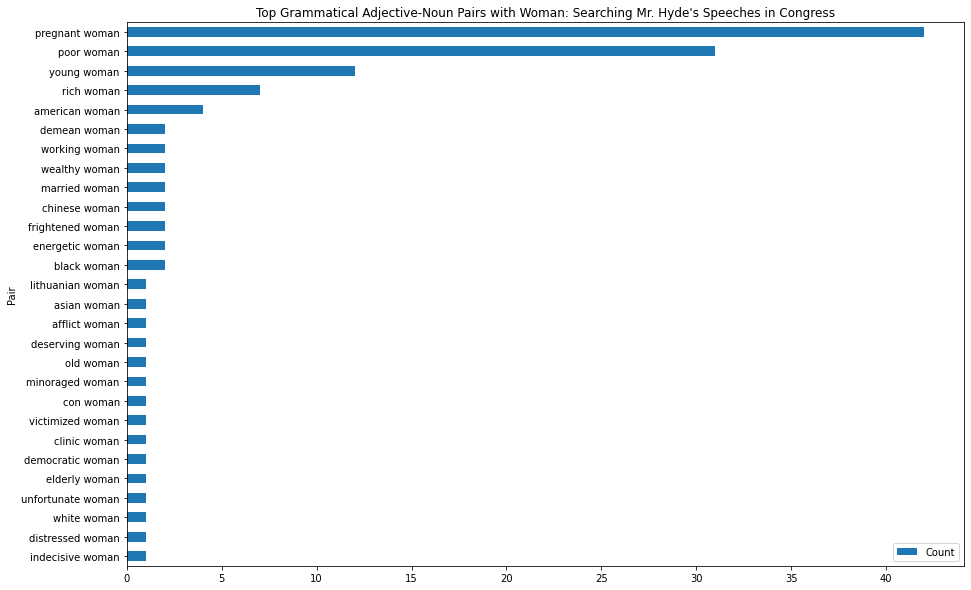

In [51]:
# remove stop words
female_adj_noun_pairs_no_stopwords = removeStopWords(female_adj_noun_pairs)

# create a dictionary with each unique pair and its frequency
female_adj_noun_dictionary = countWords(female_adj_noun_pairs_no_stopwords)

# create a data frame from our dictionary of grammatical pairs
female_adj_noun_df = pd.DataFrame(female_adj_noun_dictionary.items(),columns = ['Pair','Count'])

# arrange in ascending order
female_adj_noun_df.sort_values(by=['Count'], inplace=True, ascending=False)

top_female_adj_noun_counts = female_adj_noun_df[:45].copy()

# set the parameters of the visualization
plt.rcParams['figure.figsize'] = [15, 10]

# sort the pairs for visualization
top_female_adj_noun_counts.sort_values(by=['Count'], inplace=True, ascending=True)

# render visualization
top_female_adj_noun_counts.plot.barh(x = "Pair", y = "Count",
            title = "Top Grammatical Adjective-Noun Pairs with Woman: Searching Mr. Hyde's Speeches in Congress")

In [52]:
def extractMaleAdjNounPairs(lowercase_adjective_noun_pairs):
    regex = re.compile(' man$')
    male = [word for word in lowercase_adjective_noun_pairs if regex.search(word)]
    return male

male_adj_noun_pairs = extractMaleAdjNounPairs(lowercase_adjective_noun_pairs)

In [53]:
male_adj_noun_pairs[:30]

['young man',
 'honest man',
 'enterprising man',
 'young man',
 'creative man',
 'young man',
 'young man',
 'blind man',
 'blind man',
 'noble man',
 'lobbying man',
 'greatest man',
 'black man',
 'countryan man',
 'eminent man',
 'brilliant man',
 'young man',
 'outstanding man',
 'outstanding man',
 'young man',
 'bright man',
 'young man',
 'many man',
 'young man',
 'decent man',
 'right man',
 'first man',
 'american man',
 'front man',
 'good man']

<AxesSubplot:title={'center':"Top Grammatical Adjective-Noun Pairs with Man: Searching Mr. Hyde's Speeches in Congress"}, ylabel='Pair'>

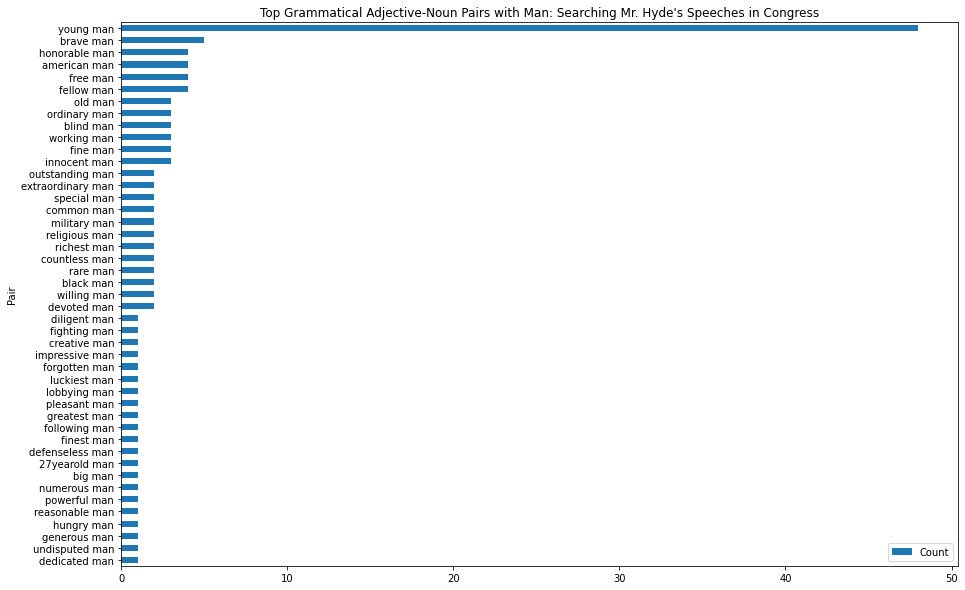

In [54]:
# remove stop words
male_adj_noun_pairs_no_stopwords = removeStopWords(male_adj_noun_pairs)

# create a dictionary with each unique pair and its frequency
male_adj_noun_dictionary = countWords(male_adj_noun_pairs_no_stopwords)

# create a data frame from our dictionary of grammatical pairs
male_adj_noun_df = pd.DataFrame(male_adj_noun_dictionary.items(),columns = ['Pair','Count'])

# arrange in ascending order
male_adj_noun_df.sort_values(by=['Count'], inplace=True, ascending=False)

top_male_adj_noun_counts = male_adj_noun_df[:45].copy()

# set the parameters of the visualization
plt.rcParams['figure.figsize'] = [15, 10]

# sort the pairs for visualization
top_male_adj_noun_counts.sort_values(by=['Count'], inplace=True, ascending=True)

# render visualization
top_male_adj_noun_counts.plot.barh(x = "Pair", y = "Count",
            title = "Top Grammatical Adjective-Noun Pairs with Man: Searching Mr. Hyde's Speeches in Congress")

In [126]:
regex = re.compile(' man/b')